In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,f1_score,confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.utils import class_weight
from xgboost import XGBClassifier
import pickle
import os
import optuna
from collections import Counter
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('train_final.csv').drop(columns = 'Unnamed: 0').sample(frac = 1)
validation = pd.read_csv('validation_final.csv').drop(columns = 'Unnamed: 0')
train.head()

,label,tweet,transformed_text,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,...,dim_290,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299
11933,1,when the waiter asks @user if he wants to eat ...,waiter asks want eat plate well,-0.053758,-0.055281,0.003843,-0.043092,-0.023579,-0.029164,0.031502,...,0.009716,0.024718,-0.008808,0.033440,0.051365,0.022327,-0.021012,0.008653,-0.040288,0.115864
9545,0,@user we've had some of that round here - but ...,round value democracy hence voting choice,-0.011539,-0.022748,-0.000703,-0.046094,-0.039533,-0.025102,0.009017,...,-0.007814,-0.022046,-0.024189,0.030091,0.004579,0.001028,-0.016738,0.014777,-0.018220,0.024861
6750,0,catchups with these cuties jcaplice @user @use...,catch ups cuties cap louse friend positive,-0.001053,-0.022454,0.052519,-0.120709,-0.099179,-0.058454,0.047138,...,-0.099811,-0.102684,-0.096895,0.103559,-0.004355,-0.114807,0.027783,-0.028831,-0.005160,-0.064972
5602,0,#germanyhetalia bull up: you will dominate y...,germany talus bull dominate bull direct whatev...,0.037659,-0.000054,-0.033957,-0.017696,-0.033497,-0.032891,-0.024620,...,0.047432,-0.020500,-0.035065,0.021086,-0.060104,0.045871,-0.068570,0.001316,-0.006666,-0.019656
11049,0,going to see the1975 again ð only this time...,going see time much love guy,-0.041699,-0.014913,-0.014300,-0.042881,-0.017215,-0.040633,-0.006785,...,-0.002748,0.019797,0.027992,0.015074,-0.010629,0.023877,-0.015061,0.035626,-0.036370,0.042530


In [3]:
train.isnull().sum()

label               0
tweet               0
transformed_text    0
dim_0               0
dim_1               0
                   ..
dim_295             0
dim_296             0
dim_297             0
dim_298             0
dim_299             0
Length: 303, dtype: int64

In [4]:
class model:
    '''
    Logistic Regression
    SVC
    XGBClassifier
    RandomForestClassifier
    GradientBoostingClassifier
    GaussianNB
    '''
    def __init__(self,model_class_weight):
        
        self.models = [LogisticRegression(class_weight=model_class_weight),SVC(class_weight=model_class_weight),
                       XGBClassifier(class_weight=model_class_weight),RandomForestClassifier(class_weight=model_class_weight)
                      ,GaussianNB(),GradientBoostingClassifier()]
        self.model_names = ['LogisticRegression','SVC','XGBClassifier','RandomForestClassifier'
                              ,'GradientBoostingClassifier','GaussianNB']
        self.X = None
        self.y = None
        
    def fit(self,X,Y):
        
        self._fitted_models = []
        for model,model_name in zip(self.models,self.model_names):
            
            globals()['model_' + model_name] = model
            globals()['model_' + model_name].fit(X,Y)
            self._fitted_models.append(globals()['model_' + model_name])
            
    def evaluate(self,X,Y):
        
        self.predictions = dict()
        self.accuracy = dict()
        self.class_report = dict()
        for fitted_model,model_name in zip(self._fitted_models,self.model_names):
            
            self.predictions[model_name] = fitted_model.predict(X)
            self.accuracy[model_name] = accuracy_score(Y,self.predictions[model_name])
            self.class_report[model_name] = classification_report(Y,self.predictions[model_name])
            
    def print_results(self):
        
        
        for model in self.model_names:
            
            print(model)
            print('-'*80)
            print("Accuracy :  {:.6}%".format(self.accuracy[model]*100))
            print('Classification Report')
            print(self.class_report[model])
            print('- -'*40)
            print('- -'*40)
        
        
    def voting_fit(self,X,Y):
        
        estimators = [(model_name,model) for model_name,model in zip(model_names,self.models)]
        
        voter = VotingClassifier(estimators=estimators,n_jobs = -1,verbose = True)
        voter.fit(X,Y)
        
        self.__voting_classifier = voter
        
    def voting_evaluate(self,X,Y):
        
        voter = self.__voting_classifier
        predictions = voter.predict(X)
        fitted_models = voter.estimators_
        for fitted_model,model_name in zip(fitted_models,self.model_names):
            
            each_model_predictions = fitted_model.predict(X)
            each_model_accuracy  = accuracy_score(Y,each_model_predictions)
            
            print("{} gave {:.6}% accuracy".format(model_name,each_model_accuracy*100))
            
        accuracy = accuracy_score(Y,predictions)
        class_report = classification_report(Y,predictions)
        
        return accuracy,class_report,predictions
    


In [5]:
model_class_weight = class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(train['label']),y = train['label'])
weights = {}
for i,cls_weight in enumerate(model_class_weight):
    weights[i] = cls_weight
weights  

{0: 0.5758604690399866, 1: 3.7955240478176258}

In [9]:
base_model = model(weights)
base_model.fit(np.array(train.iloc[:,3:]),train['label'])
base_model.evaluate(np.array(validation.iloc[:,3:]),validation['label'])
base_model.print_results()
os.makedirs('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/Models')
with open('Models/base_model.pkl','wb') as f:
    pickle.dump(base_model,f)

LogisticRegression
--------------------------------------------------------------------------------
Accuracy :  55.04%
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.53      0.69      5941
           1       0.11      0.82      0.20       438

    accuracy                           0.55      6379
   macro avg       0.54      0.67      0.44      6379
weighted avg       0.92      0.55      0.65      6379

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
SVC
--------------------------------------------------------------------------------
Accuracy :  57.6579%
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.56      0.71      5941
           1       0.12      0.82      0.21       438

In [4]:
def objective_rfc(trial):
    
    n_estimators = trial.suggest_int('n_estimators',500,1200,100)
    max_depth = trial.suggest_int('max_depth',3,20,1)
    min_samples_split = trial.suggest_int('min_samples_split',2,30,1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2,30,1)
    max_features = trial.suggest_categorical('max_features',['sqrt', 'log2'])
    weight_0 = trial.suggest_categorical('weight_0',list(np.linspace(0,1,50)))
    weight_1 = trial.suggest_categorical('weight_1',[1,2,3.7955240478176258,4,5,10,20,50])
    weights = {0:float(weight_0),1:float(weight_1)}
    
    rfc_model = RandomForestClassifier(n_jobs = -1,
                                      max_depth = max_depth,
                                      n_estimators = n_estimators,
                                      min_samples_split = min_samples_split,
                                      min_samples_leaf = min_samples_leaf,
                                      max_features = max_features,
                                      class_weight = weights,
                                      verbose=0
                                    )
    return cross_val_score(rfc_model,np.array(train.iloc[:,3:]).astype('float32')
                             ,train['label'],cv = 3,n_jobs = -1,scoring = 'f1').mean()

study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective_rfc,n_trials = 50)

[I 2022-02-20 01:38:35,416] A new study created in memory with name: no-name-da278570-7337-443e-a263-d78e730a0ce9
[I 2022-02-20 01:40:17,400] Trial 0 finished with value: 0.42635548775534376 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 21, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'weight_0': 0.8571428571428571, 'weight_1': 10}. Best is trial 0 with value: 0.42635548775534376.
[I 2022-02-20 01:42:14,002] Trial 1 finished with value: 0.5035519347701961 and parameters: {'n_estimators': 1000, 'max_depth': 16, 'min_samples_split': 24, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'weight_0': 0.9183673469387754, 'weight_1': 10}. Best is trial 1 with value: 0.5035519347701961.
[I 2022-02-20 01:42:45,395] Trial 2 finished with value: 0.4377635443986901 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'log2', 'weight_0': 0.2040816326530612, 'weight_1': 4}. Best is trial 1 with value: 0.

[I 2022-02-20 02:24:11,723] Trial 26 finished with value: 0.5160970656122736 and parameters: {'n_estimators': 1200, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 26, 'max_features': 'sqrt', 'weight_0': 0.7551020408163265, 'weight_1': 3.7955240478176258}. Best is trial 11 with value: 0.5270369582511419.
[I 2022-02-20 02:24:45,764] Trial 27 finished with value: 0.4907008138672044 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 25, 'max_features': 'log2', 'weight_0': 0.26530612244897955, 'weight_1': 2}. Best is trial 11 with value: 0.5270369582511419.
[I 2022-02-20 02:27:35,582] Trial 28 finished with value: 0.3904078124246842 and parameters: {'n_estimators': 1100, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'weight_0': 0.3469387755102041, 'weight_1': 20}. Best is trial 11 with value: 0.5270369582511419.
[I 2022-02-20 02:29:01,203] Trial 29 finished with value: 0.43430548068056

In [5]:
trial_rfc = study_rfc.best_trial
print('F1-Score: {}'.format(trial_rfc.value))
print("Best hyperparameters: {}".format(trial_rfc.params))

F1-Score: 0.5270369582511419
Best hyperparameters: {'n_estimators': 1200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'weight_0': 0.26530612244897955, 'weight_1': 2}


In [4]:
weights = {0: 0.26530612244897955, 1: 2}
RFC_params = {'n_estimators': 1200, 'max_depth': 20, 'min_samples_split': 2,
              'min_samples_leaf': 2, 'max_features': 'sqrt',
              'class_weight':weights
              }
RFC_Model = RandomForestClassifier(**RFC_params)
RFC_Model.fit(np.array(train.iloc[:,3:]),train['label'])
y_pred = RFC_Model.predict(np.array(validation.iloc[:,3:]))
print(accuracy_score(validation['label'],y_pred))
print(f1_score(validation['label'],y_pred))
print(confusion_matrix(validation['label'],y_pred))

0.8792914249882426
0.3636363636363637
[[5389  552]
 [ 218  220]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

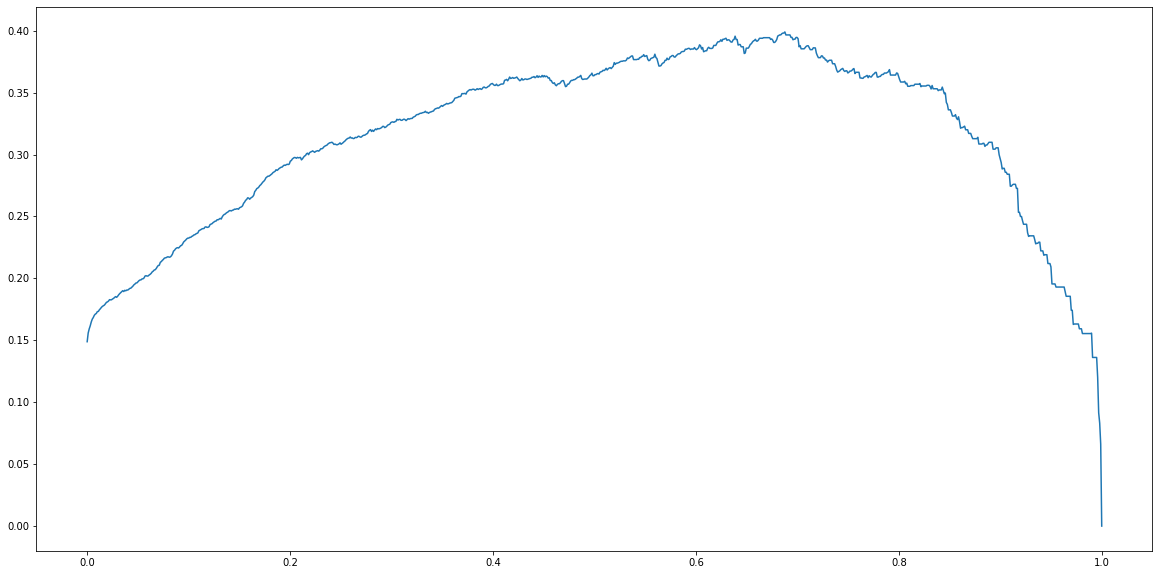

0.39903264812575573


In [8]:
y_pred_prob = RFC_Model.predict_proba(np.array(validation.iloc[:,3:]))
f1_scores_rfc = []
partition = np.linspace(0,1,1000)
for p in partition:
    pred = (y_pred_prob[:,1]>p).astype(int)
    f1_scores_rfc.append(f1_score(validation['label'],pred))
    
plt.figure(figsize = [20,10])
plt.plot(partition,f1_scores_rfc)    
plt.show()
print(max(f1_scores_rfc))

In [ ]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators',100,1000,100)
    learning_rate = trial.suggest_float('learning_rate',0.001,0.2,step=0.0001)
    max_depth = trial.suggest_int('max_depth',3,20,1)
    min_child_weight = trial.suggest_int('min_child_weight',1,13,2)
    gamma = trial.suggest_float('gamma',0,0.6,step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.2,0.9,step=0.1)
    scale_pos_weight = trial.suggest_categorical('scale_pos_weight',[1,2,3,4,5,6.5910480956352515,10,15,20,25,50,75,100])
    
    XGB_model = XGBClassifier(n_estimators = n_estimators,
                              learning_rate = learning_rate , max_depth = max_depth,
                              min_child_weight = min_child_weight , gamma = gamma,
                              colsample_bytree = colsample_bytree,
                             scale_pos_weight = scale_pos_weight)
    return cross_val_score(XGB_model,np.array(train.iloc[:,3:]).astype('float32')
                             ,train['label'],cv = 3,n_jobs = -1,scoring = 'f1').mean()

study_xgb = optuna.create_study(direction = 'maximize')
study_xgb.optimize(objective_xgb,n_trials = 50)

[I 2022-02-20 12:48:51,412] A new study created in memory with name: no-name-a2c37812-0547-415e-a44c-71794a620b81
[I 2022-02-20 12:49:26,426] Trial 0 finished with value: 0.3868955012661964 and parameters: {'n_estimators': 400, 'learning_rate': 0.11140000000000001, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.2, 'colsample_bytree': 0.2, 'scale_pos_weight': 25}. Best is trial 0 with value: 0.3868955012661964.
[I 2022-02-20 13:04:04,399] Trial 1 finished with value: 0.4933661272813814 and parameters: {'n_estimators': 400, 'learning_rate': 0.079, 'max_depth': 19, 'min_child_weight': 3, 'gamma': 0.1, 'colsample_bytree': 0.9, 'scale_pos_weight': 100}. Best is trial 1 with value: 0.4933661272813814.
[I 2022-02-20 13:08:58,479] Trial 2 finished with value: 0.5226694887748411 and parameters: {'n_estimators': 400, 'learning_rate': 0.0154, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.30000000000000004, 'scale_pos_weight': 20}. Best is trial 2 

[I 2022-02-20 15:54:10,012] Trial 26 finished with value: 0.5298917503137066 and parameters: {'n_estimators': 800, 'learning_rate': 0.027700000000000002, 'max_depth': 8, 'min_child_weight': 11, 'gamma': 0.2, 'colsample_bytree': 0.4, 'scale_pos_weight': 5}. Best is trial 20 with value: 0.5376778346064265.
[I 2022-02-20 16:11:37,044] Trial 27 finished with value: 0.5232034169984493 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0565, 'max_depth': 12, 'min_child_weight': 13, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.8, 'scale_pos_weight': 5}. Best is trial 20 with value: 0.5376778346064265.
[I 2022-02-20 16:17:24,510] Trial 28 finished with value: 0.5194247998293983 and parameters: {'n_estimators': 900, 'learning_rate': 0.08460000000000001, 'max_depth': 6, 'min_child_weight': 11, 'gamma': 0.6, 'colsample_bytree': 0.5, 'scale_pos_weight': 5}. Best is trial 20 with value: 0.5376778346064265.


In [7]:
trial_xgb = study_xgb.best_trial
print('F1-Score: {}'.format(trial_xgb.value))
print("Best hyperparameters: {}".format(trial_xgb.params))

F1-Score: 0.5376778346064265
Best hyperparameters: {'n_estimators': 800, 'learning_rate': 0.0183, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 0.4, 'colsample_bytree': 0.5, 'scale_pos_weight': 5}


In [9]:
XGB_params = {'n_estimators': 800, 'learning_rate': 0.0183, 'max_depth': 7,
              'min_child_weight': 11, 'gamma': 0.4, 'colsample_bytree': 0.5,
              'scale_pos_weight': 5}
XGB_model = XGBClassifier(**XGB_params)
XGB_model.fit(np.array(train.iloc[:,3:]),train['label'])
y_pred = XGB_model.predict(np.array(validation.iloc[:,3:]))
print(accuracy_score(validation['label'],y_pred))
print(f1_score(validation['label'],y_pred))
print(confusion_matrix(validation['label'],y_pred))

C:\Users\91988\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8739614359617495
0.39090909090909093
[[5317  624]
 [ 180  258]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

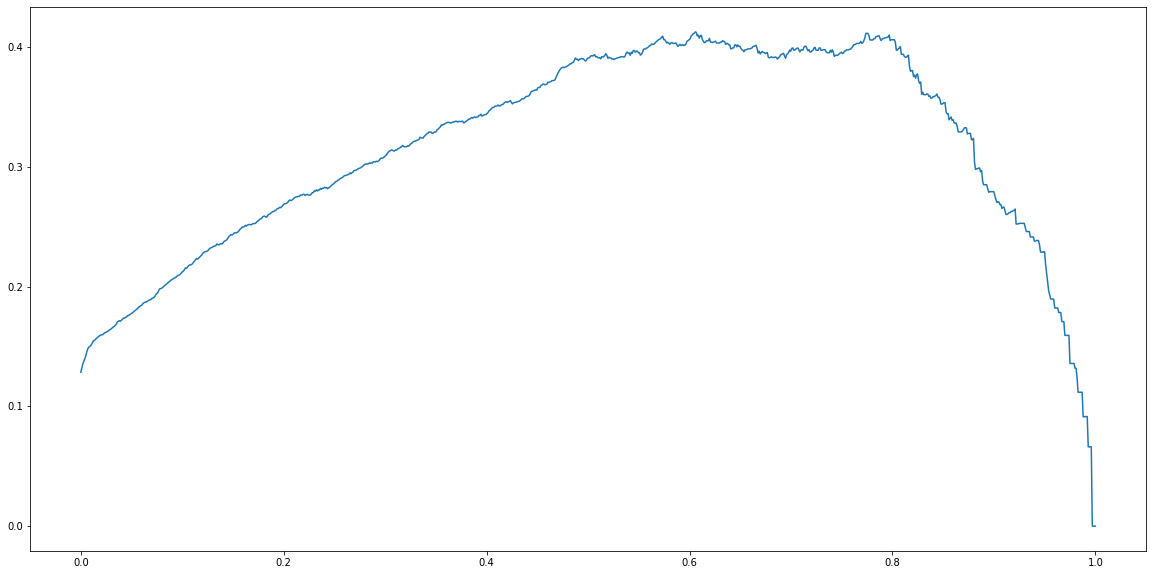

0.4128787878787879


In [10]:
y_pred_prob = XGB_model.predict_proba(np.array(validation.iloc[:,3:]))
f1_scores_xgb = []
partition = np.linspace(0,1,1000)
for p in partition:
    pred = (y_pred_prob[:,1]>p).astype(int)
    f1_scores_xgb.append(f1_score(validation['label'],pred))
    
plt.figure(figsize = [20,10])
plt.plot(partition,f1_scores_xgb)    
plt.show()
print(max(f1_scores_xgb))